In [54]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.learning_curve import learning_curve
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import cross_validation
from utilities.learning_curve import plot_learning_curve

In [85]:
#The data are extract from the csv files in two differents dataframe pandas
#Then the two dataframes,df_train and df_test are merged together into df_total
def csv_to_dataframe(path_general,dataset):

    path=os.path.join(path_general, 'us_census_full', dataset)
    df= pd.read_csv(path, header=0,sep=',\s', na_values=["?"],engine='python')
    df=df.drop(['instance_weight'], axis=1)
    return df

path_general="/Users/pierregagliardi/DossierTravail/Programmation/PythonPath/Us_Census"
training_set='census_income_learn.csv'
testing_set='census_income_test.csv'
df_train=csv_to_dataframe(path_general,training_set)
df_test=csv_to_dataframe(path_general,testing_set)

#We concatenate the training set and the testing set, to do some manipulation on the whole set
df_total = pd.concat([df_train, df_test],ignore_index=True)

#Some feature have the wrong type when pandas read the csv,
#so we change features which has int64 type instead of object type
list_wrong_types=['veterans_benefits','own_business_or_self_employed','industry_recode','occupation_recode','year']
df_total[list_wrong_types]=df_total[list_wrong_types].applymap(str)

print('%d training examples\n'%df_train.shape[0])
print('%d testing examples\n'%df_test.shape[0])
print('%d features\n'%df_total.shape[1])

199523 training examples

99762 testing examples

41 features



In [79]:
# 4.Scaling features:
def normalized(df):
    int64Column=[c for c in df if df[c].dtype == "int64"]
    for c in int64Column:
        df.loc[:,c]=(df[int64Column]-df[int64Column].mean())/df[int64Column].std()
    return df
df_total=normalized(df_total)

In [80]:
# 5.Complete missing value:
df_total['gain_total']=df_total['capital_gains']-df_total['capital_losses']+df_total['dividends_from_stocks']
df_total['income']=df_total['wage_per_hour']*df_total['weeks_worked_in_year']

In [ ]:
# 6. Create new features Part-1:
no=['All other','Do not know']

yes=['Central or South American','Mexican (Mexicano)','Mexican-American','Other Spanish','Puerto Rican','Cuban','Chicano']

hispanic_countries=['Mexico','Puerto-Rico','Ecuador','Guatemala','Nicaragua','Guatemala','Nicaragua','Cuba','Dominican-Republic','El-Salvador']

df_hispanic=df_total[['hispanic_origin','country_of_birth_self', 'country_of_birth_father','country_of_birth_mother']]

df_total['hispanic_simplified']='no'

for i,row in df_hispanic.iterrows():
    if (row['hispanic_origin'] in yes): 
        df_total.loc[i,'hispanic_simplified']='yes'
    elif (row['hispanic_origin'] in no):
        df_total.loc[i,'hispanic_simplified']='no'
    elif (row['hispanic_origin']==np.nan):
        if (row['country_of_birth_self'] or row['country_of_birth_father']or row['country_of_birth_mother'] in hispanic_countries):
            df_total.loc[i,'hispanic_simplified']='yes'
        else:
            df_total.loc[i,'hispanic_simplified']='no'

In [ ]:
#6. Create new features Part-2:
# Creating the feature hispanic_simplified takes a long time
# The dataframe with the feature hispanic_simplified has been saved into a csv and can be loaded
#df_total.to_csv(path)
data_set_with_hispanic_simplified='census_income_new_feature.csv'
path=os.path.join(path_general, 'us_census_full', data_set_with_hispanic_simplified)

df_total= pd.read_csv(path, header=0,sep=',')

In [43]:
#Build an array of binomial number for the target
y_total= df_total['target'].map( {'- 50000.': 0, '50000+.': 1} ).astype(int).values

#Drop columsn with missing values
df_total=df_total.dropna(axis = 1)

#Drop the target column class
df_total=df_total.drop(['target'], axis=1)

#Transform the pandas dataframe into a list of dictionnaries
Listdict_feature_total=df_total.T.to_dict().values()

# For each of the possible string values that the feature can take on, 
# the vec object build a one boolean-valued feature
vec = DictVectorizer(sparse = False)
X_total=vec.fit_transform(Listdict_feature_total)

print('We have drop the columns with missing values.\n')
print('There are %d features left and %d one-hot-encoded features\n'%(df_total.shape[1],X_total.shape[1]))

We have drop the columns with missing values.

There are 31 features left and 287 one-hot-encoded features



In [44]:
X_train=X_total[:number_training_examples,:]
X_test=X_total[number_training_examples:,:]
y_train=y_total[:number_training_examples]
y_test=y_total[number_training_examples:]
X_test.shape, X_train.shape

((99762, 287), (199523, 287))

In [45]:
#Apply Chi2 test to the features, to see which features are the most correlated to the target.

#We take the fifteenth best features
k=15
ch2 = SelectKBest(chi2, k )
ch2.fit_transform(X_train, y_train)

#Enumerate the chi2 score: [(0,chi_score0),(1,chi_score1)...]
enumerate_chi2_scores=enumerate(ch2.scores_)

#Sort the chi2 score from greater to smaller
ranked_features = sorted(enumerate_chi2_scores,key=lambda x:x[1], reverse=True)

#Take the k features with the greatest score
top_ranked_features=ranked_features[:k]

#Retrieve the indices of the k features with the best chi2 scores.
top_ranked_features_indices = map(list,zip(*top_ranked_features))[0]

#Retrieve features names from the vectorizer
features_names=np.asarray(vec.get_feature_names())

#Display feature name, chi2 score, p value
for feature_pvalue in zip(features_names[top_ranked_features_indices],ch2.scores_[top_ranked_features_indices],ch2.pvalues_[top_ranked_features_indices]):
    print feature_pvalue

('capital_gains', 586898877.91127098, 0.0)
('dividends_from_stocks', 122871165.9116621, 0.0)
('capital_losses', 8590610.6017821431, 0.0)
('weeks_worked_in_year', 353029.90749081556, 0.0)
('wage_per_hour', 163659.07194978738, 0.0)
('age', 53035.765099071265, 0.0)
('num_persons_worked_for_employer', 28292.308625991805, 0.0)
('major_occupation_code=Executive admin and managerial', 10915.510123595772, 0.0)
('occupation_recode=2', 10178.481684889597, 0.0)
('major_occupation_code=Professional specialty', 8394.8884507486982, 0.0)
('education=Prof school degree (MD DDS DVM LLB JD)', 7049.3177781129143, 0.0)
('education=Masters degree(MA MS MEng MEd MSW MBA)', 6996.231329892642, 0.0)
('detailed_household_and_family_stat=Householder', 6666.4239881249277, 0.0)
('education=Bachelors degree(BA AB BS)', 6221.937640096693, 0.0)
('detailed_household_summary_in_household=Householder', 5616.1853341942779, 0.0)


In [58]:
#Log-linear classifier
clf1 = linear_model.LogisticRegression(C=1e5)
clf1.fit(X_train, y_train)
y_prediction=clf1.predict(X_test)

score=metrics.accuracy_score(y_test, y_prediction)
print('The accuracy of the logistic regression model is %.4f pct'%score)

The accuracy of the logistic regression model is 0.9535 pct


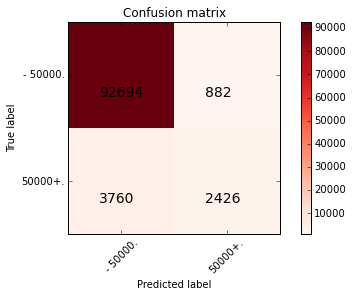

array([[92694,   882],
       [ 3760,  2426]])

In [76]:
#Plot normalised confusion matrix
 
def plot_confusion_matrix(cm, title='Normalized confusion matrix', cmap=plt.cm.Blues):
    #Normalized the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names=['- 50000.','50000+.']
    #rotation=45 represents the degree of rotation of the tick label
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    for i, cases in enumerate(cm):
        for j, case in enumerate(cases):
            if case>0:
                plt.text(j-.2, i+.2, case, fontsize=14)
    plt.show()

cm=metrics.confusion_matrix(y_test, y_prediction)
plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds)

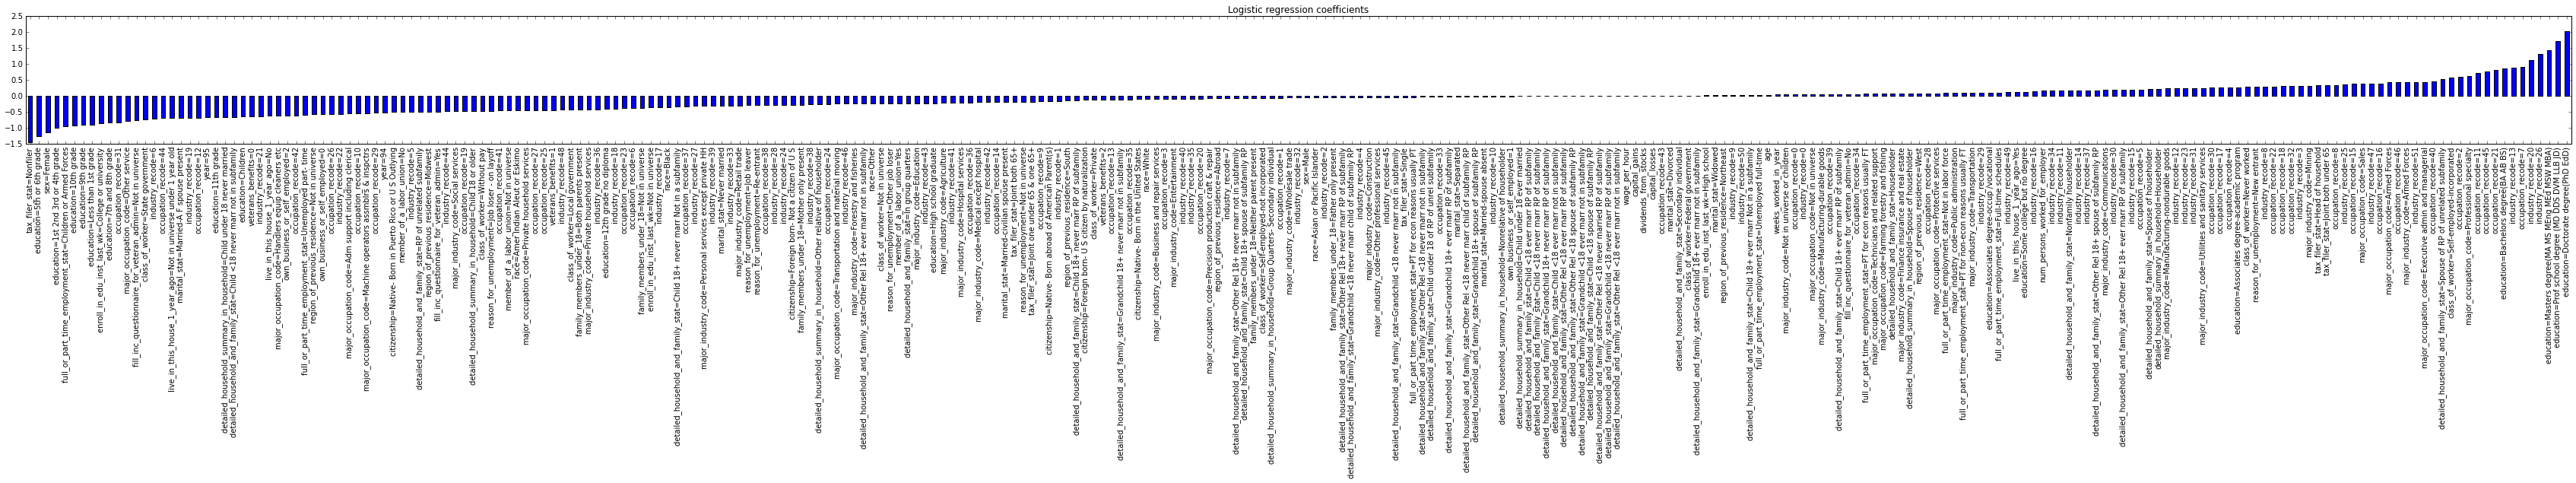

In [71]:
#Display coefficient of the log linear model
coefs = pd.Series(clf1.coef_[0], index=vec.get_feature_names())
coefs.sort()
coefs.plot(kind="bar",figsize=(60,3),title='Logistic regression coefficients')

In [30]:
#SVM classifier with RBF kernel
clf2 = svm.SVC(C=1.0, cache_size=3000, class_weight=None, coef0=0.0,
gamma=0.001, kernel='rbf', max_iter=-1, probability=False, random_state=None,
shrinking=True, tol=0.001, verbose=False)
clf2.fit(X_train, y_train)  
y_prediction2=clf2.predict(X_test)
score_svm=metrics.accuracy_score(y_test, y_prediction2)
score_svm

0.94785589703494322

In [ ]:
score_svm=metrics.accuracy_score(y_test, y_prediction2)
score_svm